In [48]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import geopandas as gpd
from datetime import datetime, timedelta
import ee
import urllib.request
import rasterio
from rasterio.mask import mask
import xarray as xr

In [49]:
# Initialize earth engine
ee.Initialize()

In [50]:
# Read Pvcia. Buenos Aires' shapefile

GDF_01 = gpd.read_file(r"GIS/pvcia_bs_as_4326.shp")

GDF_01

,OBJECTID,Entidad,Objeto,FNA,GNA,NAM,SAG,FDC,IN1,SHAPE_STAr,SHAPE_STLe,geometry
0,447,0,Provincia,Provincia de Buenos Aires,Provincia,Buenos Aires,IGN,Geografía,06,30.805998,34.035576,"POLYGON Z ((-60.27237 -33.26349 0.00000, -60.2..."


In [51]:
# For now, we'll work with Pvcia. Bs. As' bounding box
BB_01 = GDF_01.total_bounds

BB_01

array([-63.38597222, -41.03791406, -56.66499118, -33.26185025])

In [52]:
# Define coordinates
x_min, y_min, x_max, y_max = BB_01

# Create ee.Geometry
ROI = ee.Geometry.Rectangle([x_min, y_min, x_max, y_max])

ROI

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -63.385972221999964,
              -33.26185024899996
            ],
            [
              -63.385972221999964,
              -41.037914059999935
            ],
            [
              -56.66499118399997,
              -41.037914059999935
            ],
            [
              -56.66499118399997,
              -33.26185024899996
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [53]:
# Create a dictionary of image collections (one for every year)
DICT_CHIRPS_01 = {}

for YEAR in range (1981, 2024):
    
    DATE_START = f"{YEAR}-01-01"
    DATE_END = f"{YEAR+1}-01-01"

    DICT_CHIRPS_01[f"{YEAR}"] = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
                        .filterBounds(ROI) \
                        .filterDate(DATE_START, DATE_END)
DICT_CHIRPS_01

{'1981': <ee.imagecollection.ImageCollection at 0x1fb05fa6690>,
 '1982': <ee.imagecollection.ImageCollection at 0x1fb05d4c5d0>,
 '1983': <ee.imagecollection.ImageCollection at 0x1fb05d4cb10>,
 '1984': <ee.imagecollection.ImageCollection at 0x1fb05d4d050>,
 '1985': <ee.imagecollection.ImageCollection at 0x1fb05d4d590>,
 '1986': <ee.imagecollection.ImageCollection at 0x1fb05d4dad0>,
 '1987': <ee.imagecollection.ImageCollection at 0x1fb05d4e010>,
 '1988': <ee.imagecollection.ImageCollection at 0x1fb05d9e710>,
 '1989': <ee.imagecollection.ImageCollection at 0x1fb05d9f1d0>,
 '1990': <ee.imagecollection.ImageCollection at 0x1fb05d9f710>,
 '1991': <ee.imagecollection.ImageCollection at 0x1fb05d9fc50>,
 '1992': <ee.imagecollection.ImageCollection at 0x1fb7d4121d0>,
 '1993': <ee.imagecollection.ImageCollection at 0x1fb05f63b90>,
 '1994': <ee.imagecollection.ImageCollection at 0x1fb05f63610>,
 '1995': <ee.imagecollection.ImageCollection at 0x1fb05f60250>,
 '1996': <ee.imagecollection.ImageCollec

In [54]:
DICT_CHIRPS_01["1981"]

In [55]:
# Define new dictionary of images with the cumulative sum of each year
DICT_CHIRPS_02 = {}

for k, C in DICT_CHIRPS_01.items():

    DICT_CHIRPS_02[k] = C.sum()

DICT_CHIRPS_02

{'1981': <ee.image.Image at 0x1fb7d8685d0>,
 '1982': <ee.image.Image at 0x1fb7d869850>,
 '1983': <ee.image.Image at 0x1fb7d868d90>,
 '1984': <ee.image.Image at 0x1fb7d868f10>,
 '1985': <ee.image.Image at 0x1fb7d868e50>,
 '1986': <ee.image.Image at 0x1fb7d868090>,
 '1987': <ee.image.Image at 0x1fb7d86b750>,
 '1988': <ee.image.Image at 0x1fb7d86ba10>,
 '1989': <ee.image.Image at 0x1fb7d86b110>,
 '1990': <ee.image.Image at 0x1fb7d86ae10>,
 '1991': <ee.image.Image at 0x1fb7d86aad0>,
 '1992': <ee.image.Image at 0x1fb7d86b8d0>,
 '1993': <ee.image.Image at 0x1fb7d869d50>,
 '1994': <ee.image.Image at 0x1fb7d86bb90>,
 '1995': <ee.image.Image at 0x1fb7d868c50>,
 '1996': <ee.image.Image at 0x1fb7d86a8d0>,
 '1997': <ee.image.Image at 0x1fb7d86be50>,
 '1998': <ee.image.Image at 0x1fb7d86bdd0>,
 '1999': <ee.image.Image at 0x1fb7d869d90>,
 '2000': <ee.image.Image at 0x1fb7d86bf10>,
 '2001': <ee.image.Image at 0x1fb7d869210>,
 '2002': <ee.image.Image at 0x1fb7d86bed0>,
 '2003': <ee.image.Image at 0x1f

In [56]:
DICT_CHIRPS_02["1981"]

In [57]:
# Create new image collection containin the images we've defined before (each pixel we'll have 43 values, 1 for every year of the analysis)

# Create empty image collection
CHIRPS_IC_01 = ee.ImageCollection([])

for k, I in DICT_CHIRPS_02.items():
    
    # Append image to image collection
    CHIRPS_IC_01 = CHIRPS_IC_01.merge(ee.ImageCollection([I]))

CHIRPS_IC_01

In [58]:
# Create new image with the mean of the image collection we' ve defined previously
CHIRPS_I_01 = CHIRPS_IC_01.mean()

CHIRPS_I_01

In [59]:
# Calculate the anomaly as the difference between 2023 cumulative precipitation and the mean annual precipitation
CHIRPS_AN_2023 = DICT_CHIRPS_02["2023"].subtract(CHIRPS_I_01)

CHIRPS_AN_2023

In [60]:
# Get spatial resolution
OS = DICT_CHIRPS_01["2023"].first().projection().nominalScale().getInfo()

print(f"Original scale: {OS:.1f} m")

Original scale: 5566.0 m


In [61]:
# Download images locally

for I, DESC in zip([CHIRPS_I_01, CHIRPS_AN_2023, DICT_CHIRPS_02["2023"]], ["HIST", "ANOM", "2023"]):

  FN = f"PPTAC-CHIRPS-BSAS-{DESC}.tif"

  # Define the export parameters.
  url = I.getDownloadURL({
  "bands" : ["precipitation"],
  "scale" : OS,
  "crs" : "EPSG:4326",
  "region" : ROI,
  "filePerBand": False,
  "format" : "GEO_TIFF"
  })

  # Start downloading
  urllib.request.urlretrieve(url, fr"Output/{FN}")
  print(f"{FN} downloaded!")

PPTAC-CHIRPS-BSAS-HIST.tif downloaded!
PPTAC-CHIRPS-BSAS-ANOM.tif downloaded!
PPTAC-CHIRPS-BSAS-2023.tif downloaded!


In [62]:
DICT_Rs_01 = {}

for DESC in ["HIST", "ANOM", "2023"]:

    FN = f"PPTAC-CHIRPS-BSAS-{DESC}.tif"

    DICT_Rs_01[f"{DESC}"] = rasterio.open(fr"Output/{FN}")

DICT_Rs_01

{'HIST': <open DatasetReader name='Output/PPTAC-CHIRPS-BSAS-HIST.tif' mode='r'>,
 'ANOM': <open DatasetReader name='Output/PPTAC-CHIRPS-BSAS-ANOM.tif' mode='r'>,
 '2023': <open DatasetReader name='Output/PPTAC-CHIRPS-BSAS-2023.tif' mode='r'>}

In [63]:
# Clip images by Buenos Aires province shapefile

DICT_Rs_02 = {}

for k, R in DICT_Rs_01.items():
    
    out_image, out_transform = mask(R, GDF_01.geometry, crop=True, nodata=np.nan)
    
    # Store the clipped image   
    DICT_Rs_02[f"{k}"] = out_image[0]

DICT_Rs_02

{'HIST': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'ANOM': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 '2023': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [64]:
# Define palettes

# Cumulated PPT palette
pp_hex = ['ffffff', 'd9eafd', 'b3d6fb', '8ec2f9', '68aef7',  '439af5', '2186f3', '0062f1', '0051d8', '0040bf', '0030a6', '00208d', '001174', '00005b', '000042']

pp_rgba = [colors.hex2color('#' + hex_color + 'FF') for hex_color in pp_hex]

pp_palette = ListedColormap(pp_rgba)

In [65]:
# Anomaly PPT palette
an_hex = ['a50026', 'd73027', 'f46d43', 'fdae61', 'fee08b', 'ffffff', 'd9ef8b', 'a6d96a', '66bd63', '1a9850', '006837']

an_rgba = [colors.hex2color('#' + hex_color + 'FF') for hex_color in an_hex]

an_palette = ListedColormap(an_rgba)

In [73]:
# Define figure parameters

# Aspect
IMG_RATIO = DICT_Rs_02["2023"].shape[1] / DICT_Rs_02["2023"].shape[0]

# Define width and height
W = 7
H = W * IMG_RATIO

# Set figure bounds
BOUNDS = DICT_Rs_01["2023"].bounds

# Set fontsizes
T_FS = 14
AX_FS = 12

In [74]:
# Read complimentary shapefile with Buenos Aires province districts to add context
GDF_02 = gpd.read_file(r"GIS/limites_partidos.shp")

GDF_02

,cca,cde,fna,gna,nam,sag,ara3,arl,geometry
0,045,06357,Partido de General Pueyrredón,Partido,General Pueyrredón,ARBA,1463.50,1460.74,"POLYGON ((-57.53723 -38.05888, -57.53628 -38.0..."
1,055,06441,Partido de La Plata,Partido,La Plata,ARBA,892.63,942.23,"MULTIPOLYGON (((-58.14112 -34.98828, -58.15400..."
2,070,06427,Partido de La Matanza,Partido,La Matanza,ARBA,328.19,329.22,"POLYGON ((-58.58325 -34.65065, -58.58272 -34.6..."
3,030,06260,Partido de Esteban Echeverría,Partido,Esteban Echeverría,ARBA,120.45,120.22,"POLYGON ((-58.50765 -34.73163, -58.50743 -34.7..."
4,074,06560,Partido de Moreno,Partido,Moreno,ARBA,186.05,186.13,"POLYGON ((-58.77694 -34.55792, -58.77317 -34.5..."
...,...,...,...,...,...,...,...,...,...
138,113,06182,Partido de Coronel Rosales,Partido,Coronel Rosales,ARBA,1283.36,1622.60,"POLYGON ((-61.74209 -38.62701, -61.74017 -38.6..."
139,357,06805,Partido de Islas Tigre,Partido,Islas Tigre,ARBA,280.36,NaN,"POLYGON ((-58.64952 -34.26660, -58.63820 -34.2..."
140,398,06763,Partido de Islas de San Nicolas,Partido,Islas de San Nicolas,ARBA,16.47,NaN,"POLYGON ((-60.25518 -33.26897, -60.25471 -33.2..."
141,081,06616,Partido de Pellegrini,Partido,Pellegrini,ARBA,1823.13,1820.17,"POLYGON ((-63.38528 -35.88376, -63.36763 -35.8..."


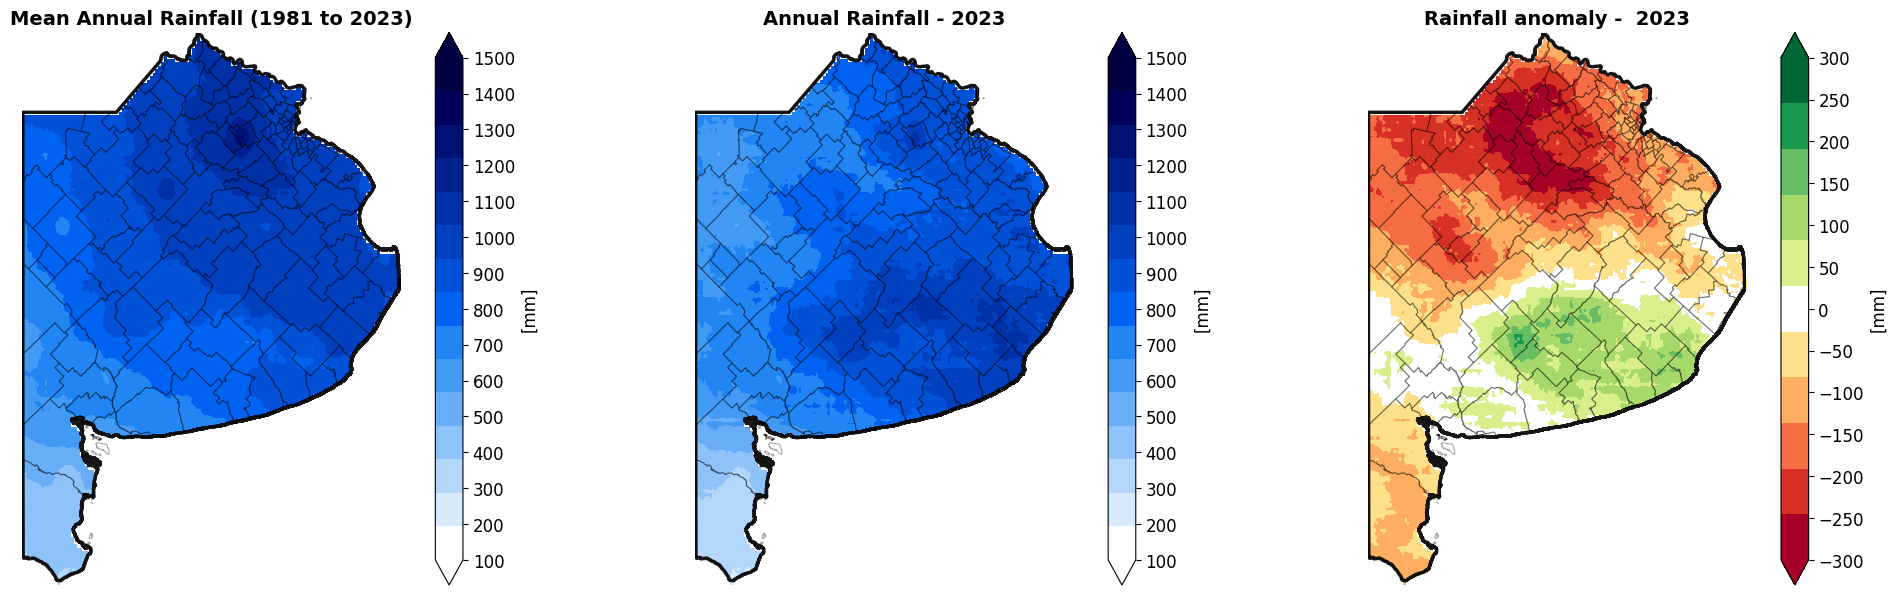

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(3*W, H))

# Mean annual rainfall
_ = ax[0].imshow(DICT_Rs_02["HIST"], vmin=100, vmax=1500, cmap=pp_palette, extent=(BOUNDS.left, BOUNDS.right, BOUNDS.bottom, BOUNDS.top), aspect=1/IMG_RATIO)
ax[0].set_title(f"Mean Annual Rainfall (1981 to 2023)", fontweight="bold", fontsize=T_FS)
CB_0 = plt.colorbar(_, extend="both", ticks=np.arange(100, 1600, 100))

# annual rainfall 2023
_ = ax[1].imshow(DICT_Rs_02["2023"], vmin=100, vmax=1500, cmap=pp_palette, extent=(BOUNDS.left, BOUNDS.right, BOUNDS.bottom, BOUNDS.top), aspect=1/IMG_RATIO)
ax[1].set_title(f"Annual Rainfall - 2023", fontweight="bold", fontsize=T_FS)
CB_1 = plt.colorbar(_, extend="both", ticks=np.arange(100, 1600, 100))

# Rainfall anomaly 2023
_ = ax[2].imshow(DICT_Rs_02["ANOM"], vmin=-300, vmax=300, cmap=an_palette, extent=(BOUNDS.left, BOUNDS.right, BOUNDS.bottom, BOUNDS.top), aspect=1/IMG_RATIO)
ax[2].set_title(f"Rainfall anomaly -  2023", fontweight="bold", fontsize=T_FS)
CB_2 = plt.colorbar(_, extend="both", ticks=np.arange(-400, 450, 50))

for ax, CB in zip(ax.ravel(), [CB_0, CB_1, CB_2]):

    GDF_01.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=2.5, alpha=.9)

    GDF_02.plot(ax=ax, facecolor="none", edgecolor="black", zorder=2, linewidth=0.75, alpha=.35)

    ax.axis("off")

    CB.ax.tick_params(labelsize=AX_FS)
    
    CB.set_label("[mm]", fontsize=AX_FS)
    
fig.tight_layout()
plt.savefig(r"Output/_01.png")
plt.show();